In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense
from keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix

In [2]:
train_path = os.getcwd()+'/train'

### count the images

In [3]:
def count_image(file_path):
    for i in os.listdir(file_path):
        print('there are ' + str(len(os.listdir(file_path + '/' + i))) + ' images of ' + i +' in the ' +file_path.split('/')[-1]+ ' data')

In [4]:
count_image(train_path)

there are 287 images of Cleavers in the train data
there are 385 images of Sugar beet in the train data
there are 611 images of Common Chickweed in the train data
there are 654 images of Loose Silky-bent in the train data
there are 516 images of Scentless Mayweed in the train data
there are 231 images of Shepherds Purse in the train data
there are 475 images of Fat Hen in the train data
there are 221 images of Common wheat in the train data
there are 263 images of Black-grass in the train data
there are 496 images of Small-flowered Cranesbill in the train data
there are 390 images of Charlock in the train data
there are 221 images of Maize in the train data


### visualize the images distribution

In [5]:
img_count=[]
for i in os.listdir(train_path):
    img_count.append(len(os.listdir(train_path + '/' + i)))

In [6]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(os.listdir(train_path)))]

In [7]:
df = pd.DataFrame({'seedling':np.array(os.listdir(train_path)), 'count':np.array(img_count), 'color':np.array(color)})

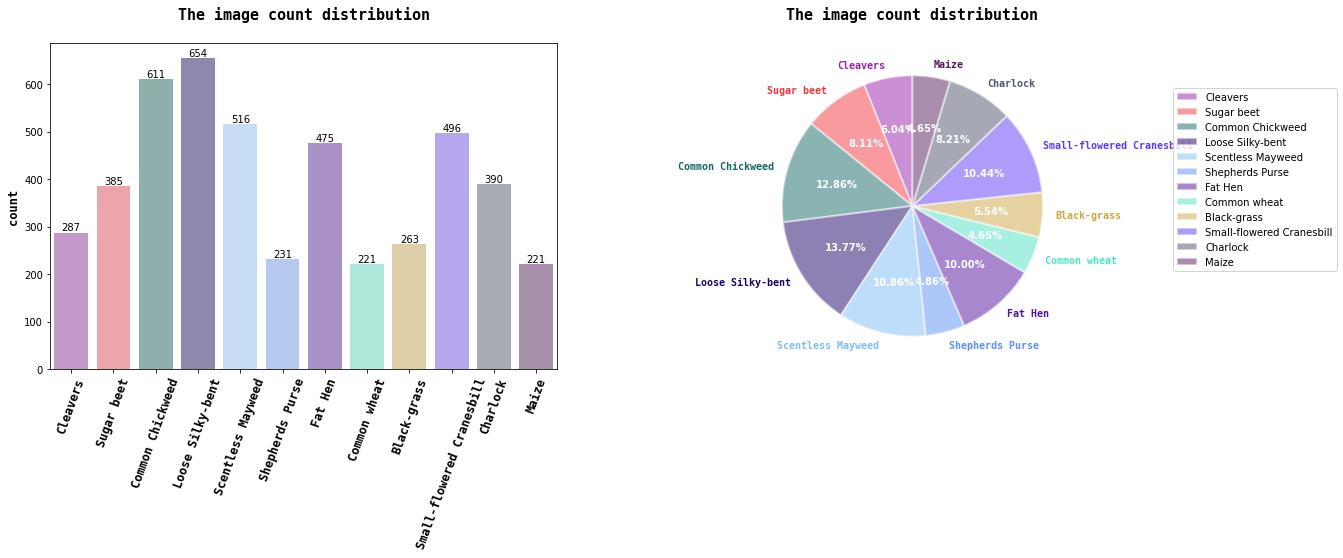

In [8]:
fig,axes = plt.subplots(1,2,figsize=(20,6))
sns.barplot(data=df, x='seedling', y='count',ax=axes[0], alpha=0.5, palette=df['color'])
for i in axes[0].get_xticklabels():
    i.set_rotation(70)
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)



patches, texts, pcts = axes[1].pie(df['count'], labels=df['seedling'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%', colors=df['color']);
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1.3,0.3])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

### see the images

In [9]:
img_path = []
for i in os.listdir(train_path):
    imgs = os.listdir(train_path + '/' + i)
    selected_imgs = np.random.choice(imgs, 5)
    for j in selected_imgs:
        img_path.append(os.path.join(train_path, i, j))

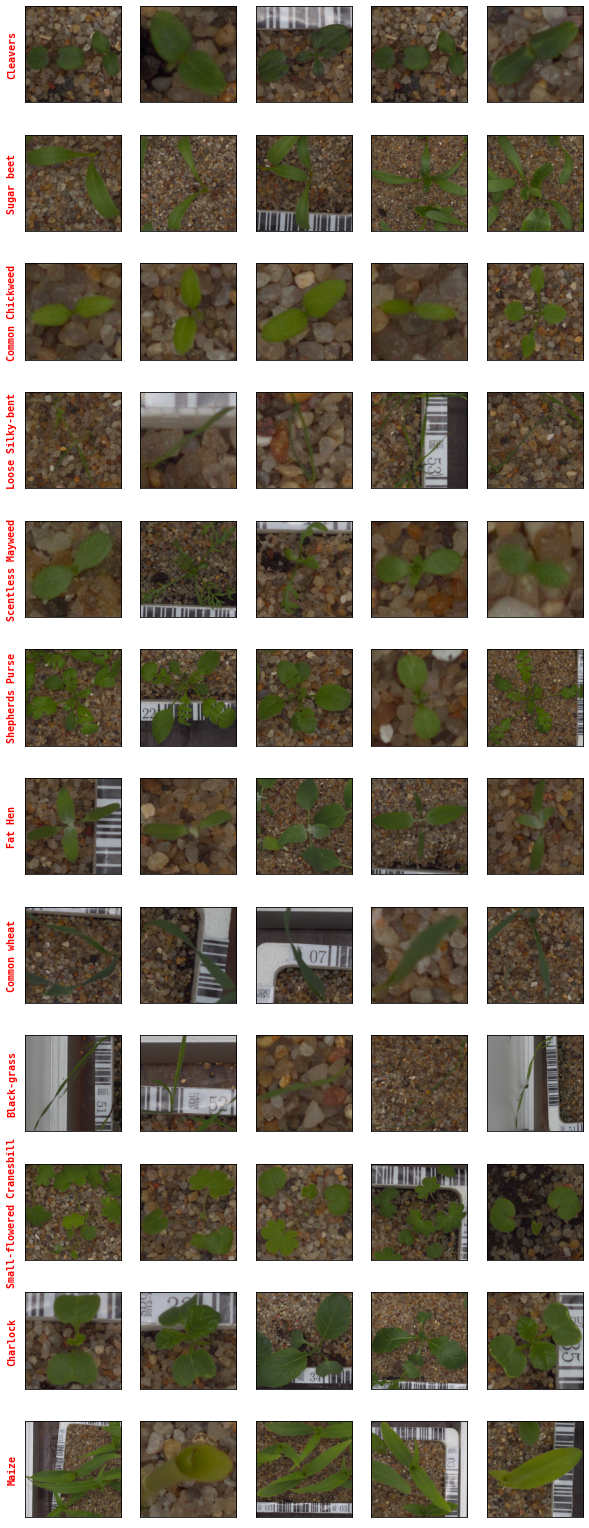

In [10]:
fig, axes = plt.subplots(len(os.listdir(train_path)),5, figsize=(10,28), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(img_path[i]))
for j, seedling in enumerate(os.listdir(train_path)):
    axes[j, 0].set_ylabel(seedling, font='monospace', weight='semibold', color='r')

In [11]:
def show_img(seedling, num):
    img = os.listdir(train_path+'/'+seedling)
    select_imgs = np.random.choice(img, num)
    img_path=[]
    for i in select_imgs:
        img_path.append(os.path.join(train_path, seedling, i)) 
    
    fig, axes = plt.subplots(1, num,figsize=(20,6), subplot_kw=dict(xticks=[], yticks=[]) )
    for j, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(img_path[j]))

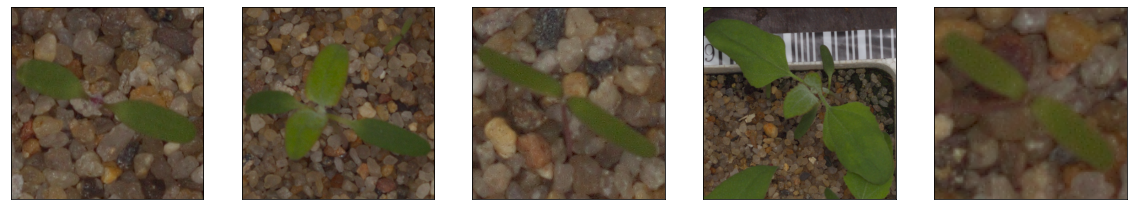

In [12]:
show_img('Fat Hen', 5 )

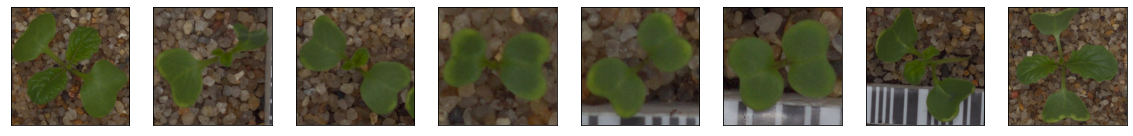

In [13]:
show_img('Charlock', 8)

### create training and validation sets

In [17]:
img_path = os.getcwd()+'/train/*/*.png'
images = glob(img_path)
Xtrain=[]
ytrain=[]

for img in images:
    Xtrain.append(cv2.resize(cv2.imread(img), (128, 128)))
    ytrain.append(img.split('/')[-2])

Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

In [18]:
encoder = LabelEncoder()
ytrain = encoder.fit_transform(ytrain)
ytrain = np_utils.to_categorical(ytrain)

In [19]:
X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=101)

### data preprocessing

In [20]:
def mask_image(image):
    # Convert to HSV image
    HSV_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # create a mask for the image
    sensitivity = 35
    low_hsv = np.array([60-sensitivity, 100, 50])
    up_hsv = np.array([60+sensitivity, 255, 255])
    mask = cv2.inRange(HSV_img, low_hsv, up_hsv )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

In [21]:
def segment_image(image):
    mask = mask_image(image)
    output = cv2.bitwise_and(image, image, mask=mask)
    return output

In [22]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [23]:
def show_img_processing(img_num):
    fig, axes = plt.subplots(1, 4, figsize=(20,5), subplot_kw=dict(xticks=[], yticks=[]))
    axes[0].imshow(Xtrain[img_num])
    axes[0].set_title(f'Original Image:{encoder.classes_[np.argmax(ytrain[img_num])]}')
    axes[1].imshow(mask_image(Xtrain[img_num]))
    axes[1].set_title(f'Image Mask:{encoder.classes_[np.argmax(ytrain[img_num])]}')
    axes[2].imshow(segment_image(Xtrain[img_num]))
    axes[2].set_title(f'Segmented Image:{encoder.classes_[np.argmax(ytrain[img_num])]}')
    axes[3].imshow(sharpen_image(segment_image(Xtrain[img_num])))
    axes[3].set_title(f'Sharpened Image:{encoder.classes_[np.argmax(ytrain[img_num])]}')

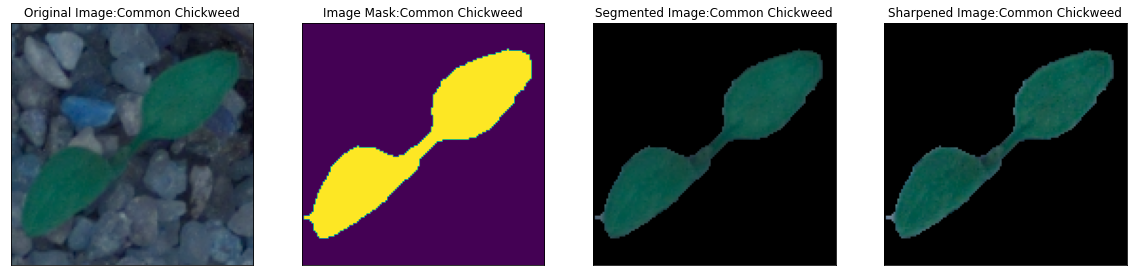

In [49]:
show_img_processing(1015)

In [25]:
X_Train = []
for i in X_train:
    X_Train.append(sharpen_image(segment_image(i)))

In [26]:
X_Validation = []
for i in X_validation:
    X_Validation.append(sharpen_image(segment_image(i)))

In [27]:
X_train = np.array(X_Train)
X_validation = np.array(X_Validation)

### build the CNN mdoel

In [28]:
model = Sequential()

model.add(Conv2D(64, (3,3),  padding='same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5),  padding='same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3),  padding='same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3),  padding='same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(12, activation='softmax'))
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


2023-01-25 10:59:51.518967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       2

In [29]:
data_gen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,width_shift_range=0.1,  
        height_shift_range=0.1)
train_generator = data_gen.flow(X_train, y_train, batch_size=75)

data_gen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,width_shift_range=0.1,  
        height_shift_range=0.1)
validation_generator = data_gen.flow(X_validation, y_validation, batch_size=75)

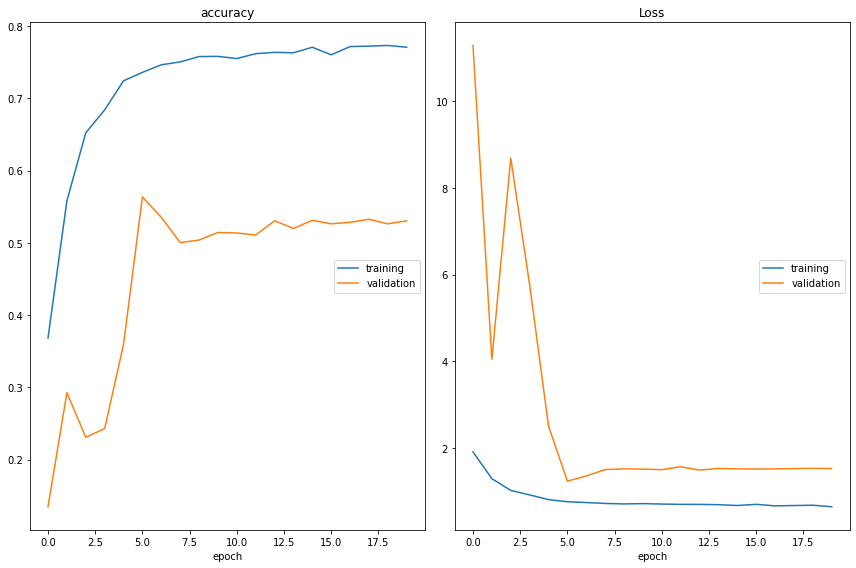

accuracy
	training         	 (min:    0.368, max:    0.773, cur:    0.771)
	validation       	 (min:    0.135, max:    0.564, cur:    0.531)
Loss
	training         	 (min:    0.645, max:    1.912, cur:    0.645)
	validation       	 (min:    1.236, max:   11.290, cur:    1.524)

Epoch 20: saving model to model_weights.h5
44/44 [==============================] - 281s 6s/step - loss: 0.6454 - accuracy: 0.7708 - val_loss: 1.5239 - val_accuracy: 0.5305 - lr: 1.0000e-05


In [30]:
epochs = 20
steps_per_epoch = train_generator.n//75
validation_steps = validation_generator.n//75

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy',
                            save_weight_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x = train_generator, steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=validation_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)

### evaluate the model

In [35]:
model.evaluate(validation_generator)

19/19 [==============================] - 30s 2s/step - loss: 1.5236 - accuracy: 0.5298


[1.5236150026321411, 0.5298245549201965]

In [36]:
y_pred = model.predict(validation_generator, validation_generator.n//validation_generator.batch_size)

19/19 [==============================] - 30s 2s/step


In [37]:
Y = np.argmax(y_pred, axis=1)

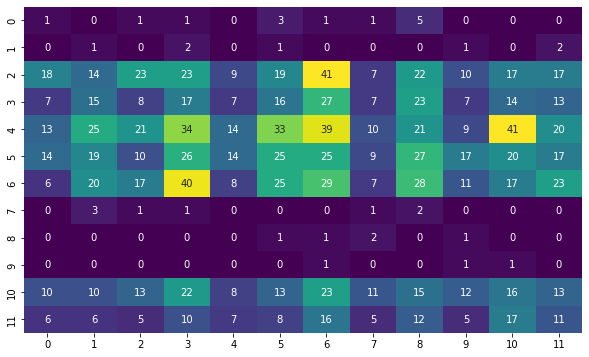

In [46]:
sns.heatmap(confusion_matrix(Y, np.argmax(validation_generator.y, axis=1)), annot=True, cbar=False, cmap='viridis' )
fig = plt.gcf()
fig.set_size_inches(10,6)